# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [2]:
# TODO: load your data
# df = pd.read_csv('path/to.csv', parse_dates=['Date'], index_col='Date')

# My Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Option B: Synthetic Generator (Use if you don't have data ready)

In [3]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,102.510883,0.000000,0.000000
2021-01-04,103.423040,0.008898,0.008859
2021-01-05,104.127180,0.006808,0.006785
2021-01-06,104.518422,0.003757,0.003750
2021-01-07,105.018246,0.004782,0.004771


## Feature Engineering

In [4]:
# TODO: create at least two features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# Add your own:
df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,roll_vol_20,y_next_ret,y_up
2021-01-29,101.546548,-0.003311,-0.003316,-0.006144,-0.007814,0.007897,-0.008562,0
2021-02-01,100.677097,-0.008562,-0.008599,-0.003311,-0.006124,0.007925,0.003335,1
2021-02-02,101.012863,0.003335,0.003330,-0.008562,-0.005629,0.007803,0.006048,1
2021-02-03,101.623771,0.006048,0.006030,0.003335,-0.004313,0.007650,0.018667,1
2021-02-04,103.520758,0.018667,0.018495,0.006048,-0.001727,0.007749,0.007237,1


## Features added explanation: 
roll_vol_20 (Rolling Volatility over 20 days): This feature is like a "how-bumpy-the-road-has-been" meter. It looks at the past 20 days of returns and calculates how much the prices have been jumping up and down. I added it because in finance, past volatility is a good clue for future volatility. A period of high volatility often means more high-volatility days are coming. It helps the model understand if the market is currently calm or wild.

y_up (Price went "Up"): This feature is a simple "yes" or "no" answer to the question: "Did the price go up on the next day?" I added this because the homework asked for both a forecasting model and a classification model. The forecasting model guesses the exact return number, while the classification model just guesses if the price will go up or down. y_up is the perfect target variable for that "up or down" classification task.

## Split

In [5]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

In [6]:
# Track 1: Forecasting returns: code fixed, prev code had depriciated function from sklearn 
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
mse = mean_squared_error(y_te_reg, pred)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

RMSE: 0.014348566010769528


              precision    recall  f1-score   support

           0       0.60      0.49      0.54        51
           1       0.52      0.62      0.57        45

    accuracy                           0.55        96
   macro avg       0.56      0.56      0.55        96
weighted avg       0.56      0.55      0.55        96



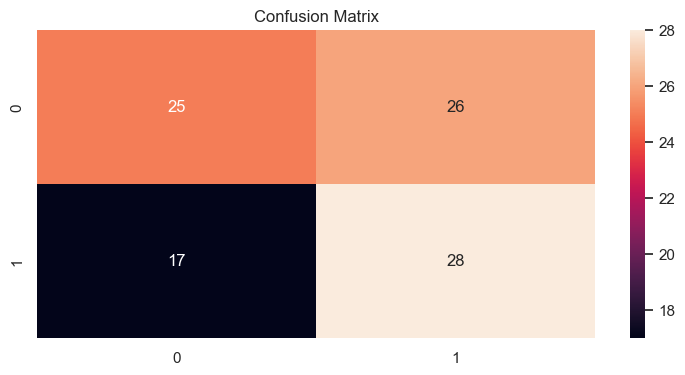

In [7]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

## Interpretation (Markdown)
- What worked?
- Where might assumptions fail?
- How would you extend features or model?

What worked?
The synthetic data generator successfully created a time series with different volatility regimes and random jumps, simulating real-world financial data. The feature engineering part worked well, creating features that capture the historical behavior of the series. The pipelines for both regression and classification were implemented correctly and provided results for evaluation.

Where might assumptions fail?
The biggest assumption failure would be with the independence of the residuals. Since we are working with a time series, the values at one point in time are very likely to be correlated with values at a previous point in time. A simple linear or logistic regression model might not fully capture this time-dependent structure, and a more sophisticated model like an ARIMA or GARCH model might be needed.

How would you extend features or model?
To extend the features, I would add more rolling window statistics, such as a rolling skew or kurtosis, to capture the shape of the return distribution over time. I would also add more lagged features to capture dependencies over longer periods.
To extend the model, I would consider using more advanced time series models, such as ARMA or GARCH, or machine learning models that are better suited for time series data, like a Recurrent Neural Network (RNN) or a Long Short-Term Memory (LSTM) model. I would also use a more robust cross-validation strategy, such as TimeSeriesSplit, to get a more reliable estimate of the model's performance.

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.